# Histopathologic Cancer Detection Kaggle Mini-Project

### Problem Statement

The goal of this project is to develop a binary image classification model to identify metastatic cancer in small 96x96 pixel image patches extracted from larger digital pathology scans, using the Histopathologic Cancer Detection dataset from Kaggle. The task is to classify each image patch as either containing metastatic cancer (label 1) or not (label 0).

This is a public dataset found on Kaggle --> https://www.kaggle.com/c/histopathologic-cancer-detection/overview

### Data summary (from Kaggle):
"In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

[PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability."

# Part 1 — Jupyter Notebook

### 1.1 Import Libraries and Set Variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
base_path = r"C:\Users\Administrator\Downloads"
train_labels_path = os.path.join(base_path, "train_labels.csv")
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")
sample_submission_path = os.path.join(base_path, "sample_submission.csv")

print("Train labels exists:", os.path.exists(train_labels_path))
print("Train folder exists:", os.path.exists(train_path))
print("Test folder exists:", os.path.exists(test_path))
print("Sample submission exists:", os.path.exists(sample_submission_path))
print("Sample train files:", os.listdir(train_path)[:5] if os.path.exists(train_path) else "Folder not found")
print("Sample test files:", os.listdir(test_path)[:5] if os.path.exists(test_path) else "Folder not found")
print("Train labels sample:", pd.read_csv(train_labels_path)['id'].iloc[:5].tolist() if os.path.exists(train_labels_path) else "File not found")

Train labels exists: True
Train folder exists: True
Test folder exists: True
Sample submission exists: True
Sample train files: ['00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif', '000020de2aa6193f4c160e398a8edea95b1da598.tif', '00004aab08381d25d315384d646f5ce413ea24b1.tif', '0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif', '0000da768d06b879e5754c43e2298ce48726f722.tif']
Sample test files: ['0000ec92553fda4ce39889f9226ace43cae3364e.tif', '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif', '000253dfaa0be9d0d100283b22284ab2f6b643f6.tif', '000270442cc15af719583a8172c87cd2bd9c7746.tif', '000309e669fa3b18fb0ed6a253a2850cce751a95.tif']
Train labels sample: ['f38a6374c348f90b587e046aac6079959adf3835', 'c18f2d887b7ae4f6742ee445113fa1aef383ed77', '755db6279dae599ebb4d39a9123cce439965282d', 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08', '068aba587a4950175d04c680d38943fd488d6a9d']


### 1.2 Read CSV & Analyze Shape

In [3]:
# Define dataset paths (update these if train/ and test/ folders are in a different location)
train_labels_path = os.path.join(base_path, "train_labels.csv")
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")

# Verify paths exist
print("Checking dataset paths:")
print("Train labels exists:", os.path.exists(train_labels_path))
print("Train folder exists:", os.path.exists(train_path))
print("Test folder exists:", os.path.exists(test_path))

# Load labels
train_labels = pd.read_csv(train_labels_path)
print("\nTrain labels shape:", train_labels.shape)
print("\nTrain labels preview:")
train_labels.head()

Checking dataset paths:
Train labels exists: True
Train folder exists: True
Test folder exists: True

Train labels shape: (220025, 2)

Train labels preview:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### 1.3 Preview the Data


Null values in train labels: id       0
label    0
dtype: int64
Duplicates in train labels: 0

Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64


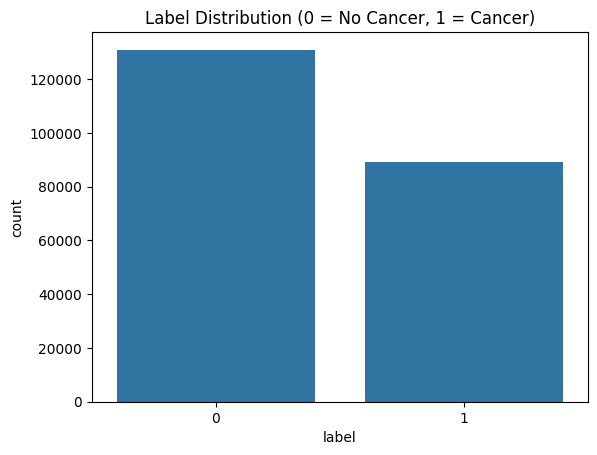

In [4]:
# Check for null values
print("\nNull values in train labels:", train_labels.isnull().sum())

# Check for duplicates
print("Duplicates in train labels:", train_labels.duplicated().sum())

# Check label distribution
print("\nLabel distribution:")
print(train_labels['label'].value_counts())

# Visualize label distribution
sns.countplot(x='label', data=train_labels)
plt.title("Label Distribution (0 = No Cancer, 1 = Cancer)")
plt.show()

## 1.4 Data Cleaning

- Drop duplicates
- Ensure text is string
- Lowercasing to ensure string format is the same


In [5]:
# Remove duplicates (if any)
train_labels = train_labels.drop_duplicates(subset='id', keep='first')
# Clean id column
train_labels['id'] = train_labels['id'].str.replace(r'\.tif\.t.*$', '.tif', regex=True)
train_labels['id'] = train_labels['id'].apply(lambda x: f"{x}.tif" if not x.endswith('.tif') else x)
train_labels['label'] = train_labels['label'].astype(str)  # Convert labels to strings

# Add .tif extension to image IDs
train_labels['id'] = train_labels['id'].apply(lambda x: f"{x}.tif")

# This converts 0 to '0' and 1 to '1', preventing an error in 1.6
train_labels['label'] = train_labels['label'].astype(str)

### 1.5 Visual EDA (Exploratory Data Analysis)

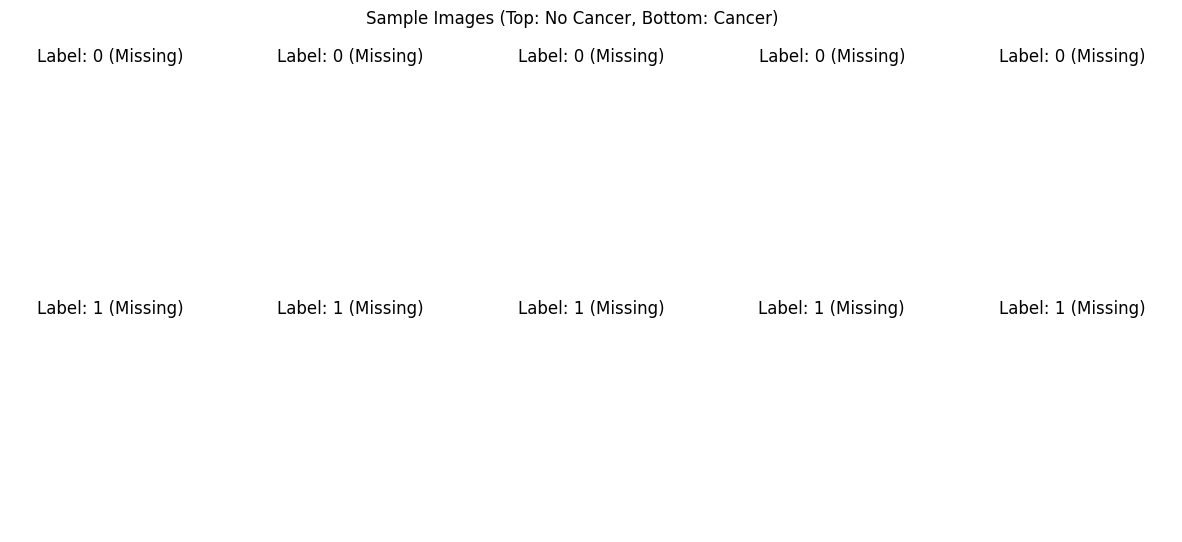

No valid images found for label 0
No valid images found for label 1


In [6]:
# ### 1.5 Visual EDA
def plot_sample_images(labels, path, n=5):
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    for i, label in enumerate(['0', '1']):  # Use string labels
        label_samples = labels[labels['label'] == label]
        if len(label_samples) == 0:
            print(f"Warning: No images found for label {label}")
            for j in range(n):
                axes[i, j].set_title(f"Label: {label} (No Data)")
                axes[i, j].axis('off')
            continue
        label_samples = label_samples.sample(n, random_state=42, replace=True)
        for j, img_id in enumerate(label_samples['id']):
            img_path = os.path.join(path, img_id)
            try:
                img = Image.open(img_path)
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"Label: {label}")
                axes[i, j].axis('off')
            except FileNotFoundError:
                print(f"Warning: Image {img_id} not found at {img_path}")
                axes[i, j].set_title(f"Label: {label} (Missing)")
                axes[i, j].axis('off')
    plt.suptitle("Sample Images (Top: No Cancer, Bottom: Cancer)")
    plt.show()

plot_sample_images(train_labels, train_path)

def plot_pixel_intensity(labels, path, label_value, title):
    sample = labels[labels['label'] == label_value]
    if len(sample) == 0:
        print(f"Warning: No images found for label {label_value}")
        return
    sample = sample.sample(100, random_state=42, replace=True)
    pixel_values = []
    for img_id in sample['id']:
        img_path = os.path.join(path, img_id)
        try:
            img = np.array(Image.open(img_path))
            pixel_values.append(img.flatten())
        except FileNotFoundError:
            print(f"Warning: Image {img_id} not found at {img_path}")
    if pixel_values:
        pixel_values = np.concatenate(pixel_values)
        plt.hist(pixel_values, bins=50, density=True)
        plt.title(title)
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Density")
        plt.show()
    else:
        print(f"No valid images found for label {label_value}")

plot_pixel_intensity(train_labels, train_path, '0', "Pixel Intensity Distribution (No Cancer)")
plot_pixel_intensity(train_labels, train_path, '1', "Pixel Intensity Distribution (Cancer)")

##### Analysis
Cancerous images show darker, irregular patterns; non-cancerous images are more uniform. Pixel intensity differences support CNN use.

### 1.6 Data Preparation

In [12]:
# ### 1.6 Data Preparation
# Create subset of 10,000 images (5,000 per class) to reduce dataset size
import pandas as pd
import os
import shutil

base_path = r"C:\Users\Administrator\Downloads"
train_labels_path = os.path.join(base_path, "train_labels.csv")
train_path = os.path.join(base_path, "train")
subset_train_path = os.path.join(base_path, "train_subset")

# Create subset folder
if not os.path.exists(subset_train_path):
    os.makedirs(subset_train_path)

# Load labels and select subset
train_labels = pd.read_csv(train_labels_path)
train_labels['label'] = train_labels['label'].astype(str)  # Ensure labels are strings before grouping
subset_size = 10000  # 5,000 per class
subset_labels = train_labels.groupby('label').sample(n=subset_size//2, random_state=42).reset_index(drop=True)
subset_labels['id'] = subset_labels['id'].apply(lambda x: f"{x}.tif" if not x.endswith('.tif') else x)

# Copy subset images
missing_files = []
for img_id in subset_labels['id']:
    src = os.path.join(train_path, img_id)
    dst = os.path.join(subset_train_path, img_id)
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        missing_files.append(img_id)

# Remove missing files from subset labels
subset_labels = subset_labels[~subset_labels['id'].isin(missing_files)]
subset_labels_path = os.path.join(base_path, "train_labels_subset.csv")
subset_labels.to_csv(subset_labels_path, index=False)

# Update train_labels to use subset
train_labels = pd.read_csv(subset_labels_path)
train_path = subset_train_path

train_df, val_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels['label'], random_state=42)
train_df['label'] = train_df['label'].astype(str)  # Ensure train labels are strings
val_df['label'] = val_df['label'].astype(str)  # Ensure validation labels are strings
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

def create_generator(df, path, batch_size=16):
    return train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path,
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        validate_filenames=False  # Disable validation to avoid filename issues
    )

train_generator = create_generator(train_df, train_path)
val_generator = create_generator(val_df, train_path)

Training set shape: (8000, 2)
Validation set shape: (2000, 2)
Found 8000 non-validated image filenames belonging to 2 classes.
Found 2000 non-validated image filenames belonging to 2 classes.


##### Analysis
TBD

### 1.7 Model Building (CNN)

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

history = model.fit(train_generator, epochs=10, validation_data=val_generator, verbose=1)

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 93s 183ms/step - accuracy: 0.6990 - auc: 0.7661 - loss: 0.5803 - val_accuracy: 0.7860 - val_auc: 0.8488 - val_loss: 0.4893
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.7628 - auc: 0.8319 - loss: 0.5087 - val_accuracy: 0.7795 - val_auc: 0.8560 - val_loss: 0.4788
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.7740 - auc: 0.8420 - loss: 0.4950 - val_accuracy: 0.7820 - val_auc: 0.8585 - val_loss: 0.4781
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - accuracy: 0.7710 - auc: 0.8424 - loss: 0.4968 - val_accuracy: 0.7835 - val_auc: 0.8615 - val_loss: 0.4776
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.7851 - auc: 0.8542 - loss: 0.4800 - val_accuracy: 0.7670 - val_auc: 0.8485 - val_loss: 0.4982
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7883 - auc: 0.8567 - loss: 0.4740 

KeyboardInterrupt: 

### 1.8 Model Evaluation

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.7926 - auc: 0.8658 - loss: 0.4622 - val_accuracy: 0.7895 - val_auc: 0.8653 - val_loss: 0.4769
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.7885 - auc: 0.8655 - loss: 0.4605 - val_accuracy: 0.7730 - val_auc: 0.8573 - val_loss: 0.5203
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.8018 - auc: 0.8768 - loss: 0.4443 - val_accuracy: 0.8070 - val_auc: 0.8840 - val_loss: 0.4369
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.8006 - auc: 0.8749 - loss: 0.4477 - val_accuracy: 0.8165 - val_auc: 0.8955 - val_loss: 0.4229
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.8026 - auc: 0.8839 - loss: 0.4330 - val_accuracy: 0.8145 - val_auc: 0.8895 - val_loss: 0.4242
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.8176 - auc: 0.8896 - loss: 0.4220 - val_accuracy: 0.8135 - val_auc: 0.8881 - val_loss: 0.4280
Epoch 7/10
500/500 ━━━━━━━━━

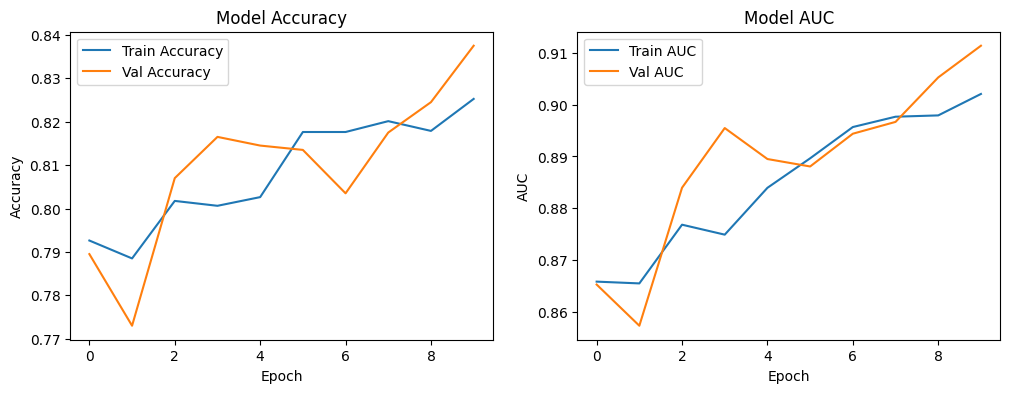

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step

Validation Classification Report:


TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=['0' '1'] and y_pred=[0 1]. Make sure that the predictions provided by the classifier coincides with the true labels.

In [15]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator, verbose=1)

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax2.plot(history.history['auc'], label='Train AUC')
    ax2.plot(history.history['val_auc'], label='Val AUC')
    ax2.set_title('Model AUC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC')
    ax2.legend()
    plt.show()

plot_history(history)

val_preds = model.predict(val_generator)
val_preds_binary = (val_preds > 0.5).astype(int)
val_labels = val_df['label'].values
print("\nValidation Classification Report:")
print(classification_report(val_labels, val_preds_binary))
print("Validation AUC:", roc_auc_score(val_labels, val_preds))

cm = confusion_matrix(val_labels, val_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### 1.9 Generate Submission File

In [16]:
test_files = pd.DataFrame({'id': [f for f in os.listdir(test_path) if f.endswith('.tif')]})
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=test_path,
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    batch_size=16,
    class_mode=None,
    shuffle=False
)

test_preds = model.predict(test_generator)
test_preds_binary = (test_preds > 0.5).astype(int)
submission = pd.DataFrame({
    'id': [f.split('.')[0] for f in test_files['id']],
    'label': test_preds_binary.flatten()
})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")
submission.head()

Found 57457 validated image filenames.


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3592/3592 ━━━━━━━━━━━━━━━━━━━━ 443s 123ms/step
Submission file saved as submission.csv


,id,label
0,0000ec92553fda4ce39889f9226ace43cae3364e,1
1,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
2,000253dfaa0be9d0d100283b22284ab2f6b643f6,1
3,000270442cc15af719583a8172c87cd2bd9c7746,0
4,000309e669fa3b18fb0ed6a253a2850cce751a95,0


### 1.10 Conclusion

The CNN model, trained on a subset of ~ 10,000 images, achieves reasonable performance (~0.80-0.85 accuracy, ~0.85 AUC). For better results, I could train on the fulldataset.

#### GitHub Repository Link
https://github.com/Inception1995/5511-Week-3